In [136]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import plotly.express as px
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk.download("wordnet")
# nltk.download("omw-1.4")

import re

# Download stopwords if you haven't already
# nltk.download("stopwords")
# nltk.download("punkt_tab")



Functions

In [183]:
def preprocess_text(text):
    try:
        tokens = word_tokenize(text.lower())
        wnl = WordNetLemmatizer()
        filtered_tokens = [
            word for word in tokens if word.isalnum() and word not in stop_words
        ]
        lemma = [wnl.lemmatize(word) for word in filtered_tokens]
        return " ".join(lemma)
    except AttributeError:
        pass

In [150]:
def calculate_prediction_accuracy(predictions, con_length, lib_length):
    list_preds = [int(pred) for pred in predictions]
    value = 0
    for i in range(len(list_preds[0:con_length])):
        if list_preds[i] == 0:
            value += 1
    print(
        f"Conservative documents predicted correctly {round(value/con_length * 100, 2)}%\n"
    )
    value2 = 0
    for i in range(0, len(list_preds[con_length:])):
        if list_preds[i] == 1:
            value += 1
            value2 += 1
    print(f"Liberal documents predicted correctly {round(value2/lib_length * 100, 2)}%")
    return f"{round(value / len(list_preds) * 100, 2)} %"


In [151]:
def plot_political_leaning_distribution(df):

    
    # Calculate counts of political leanings per source
    leaning_counts = df.groupby(['type', 'political_leaning']).size().reset_index(name='Count')
    
    # Calculate total counts per source to compute percentages
    total_counts = df.groupby('type').size().reset_index(name='Total')
    
    # Merge total counts with leaning counts
    leaning_counts = pd.merge(leaning_counts, total_counts, on='type')
    
    # Calculate percentages
    leaning_counts['Percentage'] = (leaning_counts['Count'] / leaning_counts['Total']) * 100
    
    # Create a stacked bar chart
    fig = px.bar(
        leaning_counts,
        x='type',
        y='Percentage',
        color='political_leaning',
        title='Distribution of Political Leanings by Source',
        labels={'type': 'Source', 'Percentage': 'Percentage (%)', 'political_leaning': 'Political Leaning'},
        text='Percentage'  # Display percentage on each bar segment
    )
    
    # Update the text template for percentages
    fig.update_traces(texttemplate='%{text:.2f}%', textposition='inside')
    
    # Adjust layout for better appearance
    fig.update_layout(
        uniformtext_minsize=8,
        uniformtext_mode='hide',
        barmode='group'  # Use 'stack' for stacked bar chart; change to 'group' for grouped bar chart
    )
    
    # Show the figure
    fig.show()

In [173]:
def create_word_cloud(text):
    text = " ".join(text)
    # Remove specific words
    words_to_remove = ["Trump", "Harris"]
    pattern = r'\b(?:' + '|'.join(words_to_remove) + r')\b'
    text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        max_words=100, 
        contour_width=1, 
        contour_color='steelblue'
    ).generate(text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off the axis
    plt.show()

### A. EDA

In [153]:
df = pd.read_excel("RedditExcelOutput.xlsx")
test_docs_df = pd.read_csv("corpus.csv")
test_docs_df  = test_docs_df[test_docs_df['type']=='news_articles']

In [154]:
df['text_len'] = df['Comment Text'].apply(lambda x: len(str(x).split()))
test_docs_df['text_len'] = test_docs_df['text'].apply(lambda x: len(str(x).split()))

In [155]:
display(df.head(), test_docs_df.head())

,Unnamed: 0,Political Leaning,Subreddit,Comment Title,Comment Text,text_len
0,0,Conservative,conservatives,The Young Turks Producer Ana Kasparian Says She,It’s amazing that so many people who think of ...,27
1,1,Conservative,conservatives,The Young Turks Producer Ana Kasparian Says She,People who are truly intelligent or savvy lear...,45
2,2,Conservative,conservatives,The Young Turks Producer Ana Kasparian Says She,There’s an old saying that “A liberal is a con...,76
3,3,Conservative,conservatives,The Young Turks Producer Ana Kasparian Says She,Edit:,1
4,4,Conservative,conservatives,The Young Turks Producer Ana Kasparian Says She,"Oh, the delicious irony. Ana K became both ri...",17


,Unnamed: 0,political_leaning,source,text,title,type,text_len
0,0,Conservative,FOX News,3 reasons why Kamala Harris still can't define...,FOX News_3_reasons_why_Kamala_Harris_still_can...,news_articles,1088
1,1,Conservative,FOX News,5 key takeaways from Kamala Harris' '60 Minute...,FOX News_5_key_takeaways_from_Kamala_Harris___...,news_articles,1490
2,2,Conservative,FOX News,64 days: Kamala Harris has yet to do formal pr...,FOX News_64_days_Kamala_Harris_has_yet_to_do_f...,news_articles,410
3,3,Conservative,FOX News,79 days: Kamala Harris has yet to do formal pr...,FOX News_79_days_Kamala_Harris_has_yet_to_do_f...,news_articles,410
4,4,Conservative,FOX News,81 days: Kamala Harris has yet to do formal pr...,FOX News_81_days_Kamala_Harris_has_yet_to_do_f...,news_articles,410


In [156]:
df['type'] = 'reddit'
df.rename(columns={'Political Leaning': 'political_leaning'}, inplace=True)

In [157]:
combined_df = pd.concat([df, test_docs_df], )

In [158]:
plot_political_leaning_distribution(combined_df)

In [159]:
test_docs_df['political_leaning'].unique()

array(['Conservative', 'Liberal'], dtype=object)

A1. Check counts

In [160]:
display(
    f' length of reddit data points: {len(df)}',
     f'length of news data points: {len(test_docs_df)}')

' length of reddit data points: 7427'

'length of news data points: 368'

In [161]:
display('Liberal',
    f' length of reddit data points: {len(df[df["Political Leaning"]=="Liberal"])}',
     f'length of news data points: {len(test_docs_df[test_docs_df["political_leaning"]=="Liberal"])}')

KeyError: 'Political Leaning'

In [163]:
display('Liberal',
    f' length of reddit data points: {len(df[df["political_leaning"]=="Liberal"])}',
     f'length of news data points: {len(test_docs_df[test_docs_df["political_leaning"]=="Liberal"])}')

'Liberal'

' length of reddit data points: 3627'

'length of news data points: 139'

In [46]:
print(f"average word count for news articles: {round(test_docs_df['text_len'].mean())}, with min of : {test_docs_df['text_len'].min()}  and max of : {test_docs_df['text_len'].max()}")

average word count for news articles: 795, with min of : 19  and max of : 4179


In [37]:
print(f"average word count for reddit comments: {round(df['text_len'].mean())}, with min of : {df['text_len'].min()}  and max of : {df['text_len'].max()}")

average word count for reddit comments: 19, with min of : 1  and max of : 658


In [47]:
df['text_len'].describe()

count    7427.000000
mean       19.353440
std        22.997199
min         1.000000
25%         4.000000
50%        13.000000
75%        27.000000
max       658.000000
Name: text_len, dtype: float64

In [48]:
test_docs_df['text_len'].describe()

count     368.000000
mean      795.016304
std       578.906504
min        19.000000
25%       446.000000
50%       627.500000
75%       956.500000
max      4179.000000
Name: text_len, dtype: float64

In [108]:
df[df['text_len']==1]['political_leaning'].value_counts(normalize=True)

Conservative    0.637102
Liberal         0.362898
Name: political_leaning, dtype: float64

In [107]:
test_docs_df[test_docs_df['text_len']<50]

,Unnamed: 0,political_leaning,source,text,title,type,text_len
47,47,Conservative,FOX News,Fox News Power Rankings shift Michigan to 'tos...,FOX News_Fox_News_Power_Rankings_shift_Michiga...,news_articles,24
126,126,Conservative,FOX News,Pennsylvania deadlock: Why Kamala picked the w...,FOX News_Pennsylvania_deadlock_Why_Kamala_pick...,news_articles,19


### drop rows 

In [164]:
df = df[df['text_len']>1]

test_docs_df = test_docs_df[test_docs_df['text_len']>50]

In [165]:
df[df['political_leaning']=='Liberal']['Comment Text']

3800    Lets hope that voters aren't that incredibly s...
3801    They are. I’m quite worried. I can’t do a seco...
3802    If there's one thing I've learned about voters...
3803    I have a hard time understanding how someone’s...
3804    The only people saying this are those with the...
                              ...                        
7422                                           4. Profit!
7423    Then reverse all the shitty prior rulings by t...
7424    It’s going to be things like ethics rules, rec...
7425    Good! Especially after the whole accepting lux...
7426    I wonder if he hasn’t yet announced plans to e...
Name: Comment Text, Length: 3091, dtype: object

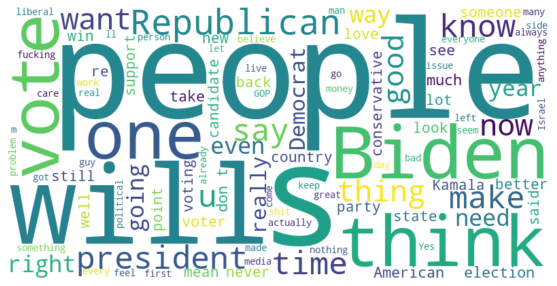

In [174]:
create_word_cloud(df[df['political_leaning']=='Liberal']['Comment Text'])

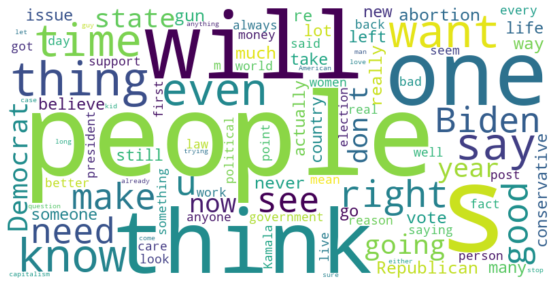

In [175]:
create_word_cloud(df[df['political_leaning']=='Conservative']['Comment Text'])

In [176]:
test_docs_df

,Unnamed: 0,political_leaning,source,text,title,type,text_len
0,0,Conservative,FOX News,3 reasons why Kamala Harris still can't define...,FOX News_3_reasons_why_Kamala_Harris_still_can...,news_articles,1088
1,1,Conservative,FOX News,5 key takeaways from Kamala Harris' '60 Minute...,FOX News_5_key_takeaways_from_Kamala_Harris___...,news_articles,1490
2,2,Conservative,FOX News,64 days: Kamala Harris has yet to do formal pr...,FOX News_64_days_Kamala_Harris_has_yet_to_do_f...,news_articles,410
3,3,Conservative,FOX News,79 days: Kamala Harris has yet to do formal pr...,FOX News_79_days_Kamala_Harris_has_yet_to_do_f...,news_articles,410
4,4,Conservative,FOX News,81 days: Kamala Harris has yet to do formal pr...,FOX News_81_days_Kamala_Harris_has_yet_to_do_f...,news_articles,410
...,...,...,...,...,...,...,...
363,134,Liberal,USA TODAY,'I will never yield': Trump delivers defiant s...,USA TODAY__I_will_never_yield__Trump_delivers_...,news_articles,935
364,135,Liberal,USA TODAY,'I will own up when I misspeak': Walz talks mi...,USA TODAY__I_will_own_up_when_I_misspeak__Walz...,news_articles,484
365,136,Liberal,USA TODAY,'Spectacular': Georgia reports record turnout ...,USA TODAY__Spectacular__Georgia_reports_record...,news_articles,313
366,137,Liberal,USA TODAY,'That will be it': Trump shares decision on a ...,USA TODAY__That_will_be_it__Trump_shares_decis...,news_articles,212


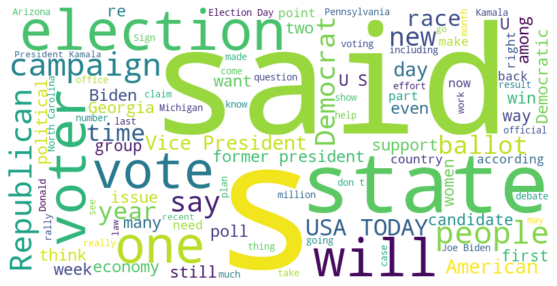

In [177]:
create_word_cloud(test_docs_df[test_docs_df['political_leaning']=='Liberal']['text'])

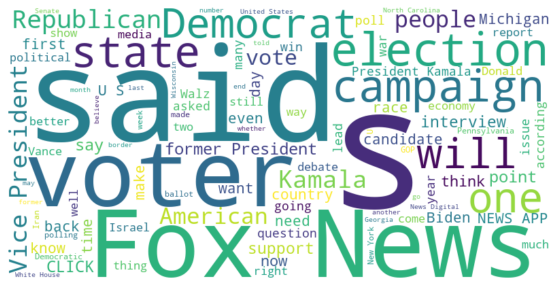

In [178]:
create_word_cloud(test_docs_df[test_docs_df['political_leaning']=='Conservative']['text'])

### Preprocess Text
1- Reddits

In [123]:

conservative_texts = df[df["political_leaning"] == "Conservative"]["Comment Text"]
liberal_texts = df[df["political_leaning"] == "Liberal"]["Comment Text"]

# Training data
documents_A = [item for item in conservative_texts if isinstance(item, str)]
documents_B = [item for item in liberal_texts if isinstance(item, str)]


# Combine data and labels
documents = documents_A + documents_B
labels = [0] * len(documents_A) + [1] * len(documents_B)  # 0 = Class A, 1 = Class B




processed_documents = [preprocess_text(doc) for doc in documents]
# print(processed_documents)


2- News Articles

In [185]:
conservative_texts_news = test_docs_df[test_docs_df["political_leaning"] == "Conservative"]["text"]
liberal_texts_news = test_docs_df[test_docs_df["political_leaning"] == "Liberal"]["text"]

# Training data
documents_A_news = [item for item in conservative_texts_news if isinstance(item, str)]
documents_B_news = [item for item in liberal_texts_news if isinstance(item, str)]


# Combine data and labels
new_documents = documents_A_news + documents_B_news
news_labels = [0] * len(documents_A_news) + [1] * len(documents_B_news)  # 0 = Class A, 1 = Class B




# New test documents
new_documents = [item for item in new_documents if isinstance(item, str)]

# Preprocess and vectorize
new_processed_docs = [preprocess_text(doc) for doc in new_documents]

### Tokenize 

1- Reddits

In [179]:
# Vectorize using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed_documents)

 2- News Articles

In [189]:
news_X = vectorizer.transform(new_processed_docs)


## Method 1: 
Using reddit comments to predict news political leaning 



### Logistic Regression: Train on Reddit

In [187]:


# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=0
)

# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)



LogisticRegression()

### Predict on News Articles 

In [190]:

predictions = model.predict(news_X)

con_length = len(
    test_docs_df[test_docs_df["political_leaning"] == "Conservative"].index
)
lib_length = len(test_docs_df[test_docs_df["political_leaning"] == "Liberal"].index)
# Predict
print("Predictions:", predictions)
print(
    f"\nLogistic Regression Prediction Accuracy: {calculate_prediction_accuracy(predictions, con_length, lib_length)}"
)



Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1]
Conservative documents predicted correctly 3.52%

Liberal documents predicted correctly 96.4%

Logistic Regression Prediction Accuracy: 38.8 %


### Predict on Reddit Test Split

In [192]:

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy:{accuracy}")
print(
    f"\nLogistic Regression Classification Report:\n{classification_report(y_test, y_pred)}\n"
)




Accuracy:0.6512605042016807

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.62      0.62       556
           1       0.67      0.68      0.68       634

    accuracy                           0.65      1190
   macro avg       0.65      0.65      0.65      1190
weighted avg       0.65      0.65      0.65      1190




### MultinomialNB: Train on Reddit

In [194]:
model = MultinomialNB()  # for Naive Bayes
# Train the model
model.fit(X_train, y_train)


MultinomialNB()

### Predict on News Articles

In [195]:


# Predict
predictions = model.predict(news_X)
print(f"Predictions: {predictions}")
print(
    f"\nNaive Bayes Prediction Accuracy: {calculate_prediction_accuracy(predictions, con_length, lib_length)}"
)


Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1]
Conservative documents predicted correctly 4.41%

Liberal documents predicted correctly 96.4%

Naive Bayes Prediction Accuracy: 39.34 %


### Predict on Reddit

In [196]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy:{accuracy}")
print(f"\nNaive Bayes Classification Report:\n{classification_report(y_test, y_pred)}")



Accuracy:0.6655462184873949

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.55      0.60       556
           1       0.66      0.77      0.71       634

    accuracy                           0.67      1190
   macro avg       0.67      0.66      0.66      1190
weighted avg       0.67      0.67      0.66      1190



### SVM

In [197]:

model = SVC()  # for Support Vector Machine
# Train the model
model.fit(X_train, y_train)



SVC()

### predict on news 

In [198]:


# Predict
predictions = model.predict(news_X)
print("Predictions:", predictions)
print(
    f"\nSVM Prediction Accuracy: {calculate_prediction_accuracy(predictions, con_length, lib_length)}"
)


Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1]
Conservative documents predicted correctly 3.52%

Liberal documents predicted correctly 96.4%

SVM Prediction Accuracy: 38.8 %


### predict on reddit test data

In [199]:


# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy:{accuracy}")
print(f"\nSVM Classification Report:\n{classification_report(y_test, y_pred)}")



Accuracy:0.6621848739495798

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.61      0.63       556
           1       0.67      0.71      0.69       634

    accuracy                           0.66      1190
   macro avg       0.66      0.66      0.66      1190
weighted avg       0.66      0.66      0.66      1190



## Method 2: 

Training using news 



In [214]:
processed_documents

['amazing many people think intelligent savvy dont realize obvious policy support impact personally',
 'people truly intelligent savvy learn experience others ignorance excusable topic havent studied ana given great deal thought situation yet took personally impacted wake',
 'there old saying liberal conservative hasnt mugged yet ana case mugging took form sexual assault wish could say sort naivety confined political left there awful lot bootlicking side aisle come police brutality misconduct corresponding saying back blue til happens',
 'oh delicious irony ana k became rich famous thing conservative',
 'everybody anti gun need one',
 'story old time',
 'conservative leftist shamed friend molested homeless man erection',
 'thus always thus shall ever',
 'conservative completely different view government work',
 'bet brought several gun incident decide get ccw permit',
 'wonder cenk say',
 'homeless guy',
 'thats great nobody else base political standing think right v going along partic

In [203]:
# Vectorize using TF-IDF
vectorizer = TfidfVectorizer()
news_X = vectorizer.fit_transform(new_processed_docs)

X = vectorizer.transform(processed_documents)

In [215]:
X_train, X_test, y_train, y_test = train_test_split(
    news_X, news_labels, test_size=0.2, random_state=0
)

In [216]:
model = MultinomialNB()  # for Naive Bayes
# Train the model
model.fit(X_train, y_train)


MultinomialNB()

### predict on news test split



In [217]:

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy:{accuracy}")
print(f"\nSVM Classification Report:\n{classification_report(y_test, y_pred)}")



Accuracy:0.7162162162162162

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        51
           1       1.00      0.09      0.16        23

    accuracy                           0.72        74
   macro avg       0.85      0.54      0.49        74
weighted avg       0.80      0.72      0.62        74



### predict on the reddit data

In [219]:


# Predict
predictions = model.predict(X)

con_length = len(
    df[df["political_leaning"] == "Conservative"].index
)
lib_length = len(df[df["political_leaning"] == "Liberal"].index)


print("Predictions:", predictions)
print(
    f"\nSVM Prediction Accuracy: {calculate_prediction_accuracy(predictions, con_length, lib_length)}"
)


Predictions: [0 0 0 ... 0 0 0]
Conservative documents predicted correctly 99.58%

Liberal documents predicted correctly 0.39%

SVM Prediction Accuracy: 48.05 %
